# Overview

Simple demo with flu model with "toy" (not necessarily realistic or finalized) parameters

We go over
- How to set up subpopulation models and metapopulation models.
- How to run accept-reject algorithm.
- How to run experiments to organize output of multiple replications. 

# Imports

In [2]:
# Misc: suppress SSE4.2 deprecation warnings
# This is not an error, just a warning about future hardware compatibility (not relevant in general)
import os
os.environ["MKL_DEBUG_CPU_TYPE"] = "5" 

from pathlib import Path
import numpy as np
import pandas as pd

# Import city-level transmission base components module
import clt_toolkit as clt

# Import flu model module, which contains customized subclasses
import flu_core as flu

# Import immunity module, which contains some nice graphing functions
#import toy_immunity_core as imm

import json

# Reading Input Files

In [3]:
# Note that this can be cumbersome due to the complexity of the model 
# Users may prefer to create the model inputs or even the models themselves in a separate .py file and import them! 

# Obtain path to folder with JSON input files
base_path = clt.utils.PROJECT_ROOT / "flu_instances" / "austin_input_files"

# Get filepaths for east subpopulation
east_compartments_epi_metrics_init_vals_filepath = base_path / "init_vals_east.json"


# Read in files as dictionaries and dataframes for east subpopulation
# Note that we can also create these dictionaries directly
#   rather than reading from a predefined input data file.
east_state = clt.make_dataclass_from_json(east_compartments_epi_metrics_init_vals_filepath,
                                     flu.FluSubpopState)
east_vaccines_df = pd.read_csv(base_path / "daily_vaccines_east.csv", index_col=0)

# Get filepaths for west subpopulation
west_compartments_epi_metrics_init_vals_filepath = base_path / "init_vals_west.json"

# Read in files as dictionaries and dataframes for west subpopulation
# Note that we can also create these dictionaries directly
#   rather than reading from a predefined input data file.
west_state = clt.make_dataclass_from_json(west_compartments_epi_metrics_init_vals_filepath,
                                     flu.FluSubpopState)
west_vaccines_df = pd.read_csv(base_path / "daily_vaccines_west.csv", index_col=0)

# Get filepaths for files shared across subpopulations
subpop_params_filepath = base_path / "common_subpop_params.json"
mixing_params_filepath = base_path / "mixing_params.json"
simulation_settings_filepath = base_path / "simulation_settings.json"

calendar_df = pd.read_csv(base_path / "school_work_calendar_austin_2023_2024.csv", index_col=0)
humidity_df = pd.read_csv(base_path / "absolute_humidity_austin_2023_2024.csv", index_col=0)

# Read in files as dictionaries and dataframes for files shared across subpopulations
# Note that we can also create these dictionaries directly
#   rather than reading from a predefined input data file.
params = clt.make_dataclass_from_json(subpop_params_filepath, flu.FluSubpopParams)
mixing_params = clt.make_dataclass_from_json(mixing_params_filepath, flu.FluMixingParams)
settings = clt.make_dataclass_from_json(simulation_settings_filepath, flu.SimulationSettings)

# Set the schedules for each subpopulation
east_schedules_info = flu.FluSubpopSchedules(absolute_humidity=humidity_df,
                                        flu_contact_matrix=calendar_df,
                                        daily_vaccines=east_vaccines_df)
west_schedules_info = flu.FluSubpopSchedules(absolute_humidity=humidity_df,
                                        flu_contact_matrix=calendar_df,
                                        daily_vaccines=west_vaccines_df)

# Create two independent bit generators
bit_generator = np.random.MT19937(88888)
jumped_bit_generator = bit_generator.jumped(1)

# Creating Subpopulation Models

In [4]:
# Create two subpopulation models, one for the east
#   side of the city and one for the west side of the city
# In this case, these two (toy) subpopulations have the
#   same demographics, initial compartment and epi metric values,
#   fixed parameters, and school-work calendar.
# If we wanted the "east" subpopulation and "west"
#   subpopulation to have different aforementioned values,
#   we could read in two separate sets of files -- one
#   for each subpopulation.
east = flu.FluSubpopModel(east_state,
                           params,
                           settings,
                           np.random.Generator(bit_generator),
                           east_schedules_info,
                           name="east")

west = flu.FluSubpopModel(west_state,
                           params,
                           settings,
                           np.random.Generator(jumped_bit_generator),
                           west_schedules_info,
                           name="west")

# If a metapopulation model has N subpopulations that have most of their parameters in common,
#    users can make a JSON file with common parameters, and N smaller JSON files with
#    parameters that are specific to each subpopulation.
# We recommend using `clt_toolkit / utils` functions `updated_dataclass()` and `updated_dict()` for this.

# Modifying Parameters

In [5]:
# We can also manually change a fixed parameter value
#   after we have created a SubpopModel -- like so...
# Note that this is quite a large and unrealistic value of
#   beta_baseline, but we'll use this to create
#   a dramatic difference between the two subpopulations.
#east.params = clt.updated_dataclass(east.params, {"beta_baseline": 10})

# The structure of the code allows us to access
#   the current state and fixed parameters of each
#   subpopulation model.
# For example, here we print out the fixed parameter
#   value for beta_baseline for the "west" subpopulation.
print(params.beta_baseline)
print(west.state.MV)
print(east.state.MV)

0.01745
[[0.278]
 [0.278]
 [0.278]
 [0.278]
 [0.278]]
[[0.228]
 [0.228]
 [0.228]
 [0.228]
 [0.228]]


# Create Metapopulation Model

In [6]:
# Combine two subpopulations into one metapopulation model (travel model)
flu_demo_model = flu.FluMetapopModel([east, west],
                                     mixing_params)

# Simulation and Analysis

In [7]:
# Get the current real date of the simulation and the
#   current simulation day
print(flu_demo_model.current_simulation_day, flu_demo_model.current_real_date)

# Simulate for a given number of days
flu_demo_model.simulate_until_day(180)

# Get the current real date of the simulation and the
#   current simulation day
print(flu_demo_model.current_simulation_day, flu_demo_model.current_real_date)

0 2023-10-20
180 2024-04-17


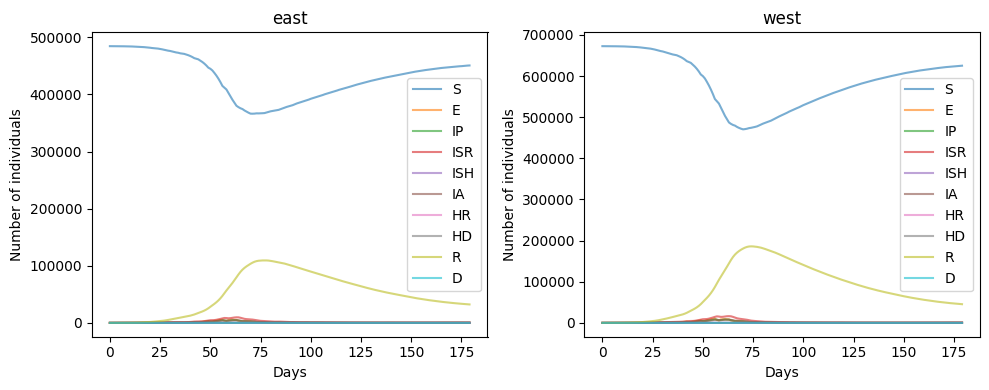

In [8]:
# Generate simple compartment history plot for flu model
clt.plot_metapop_basic_compartment_history(flu_demo_model)

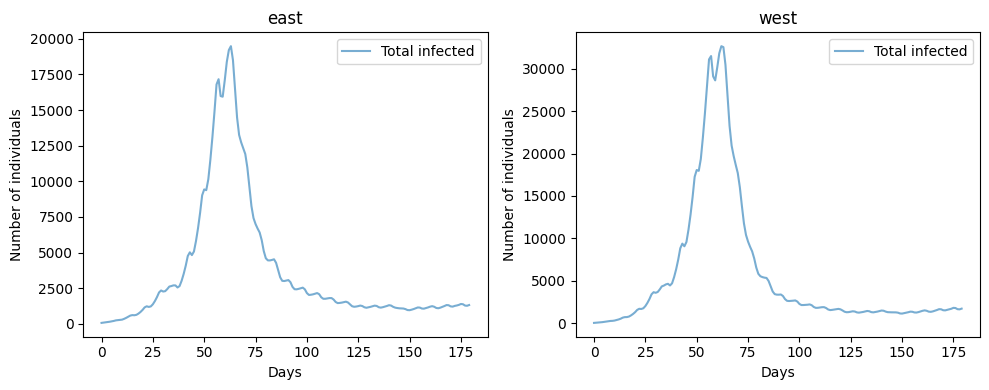

In [ ]:
clt.plot_metapop_total_infected(flu_demo_model)x


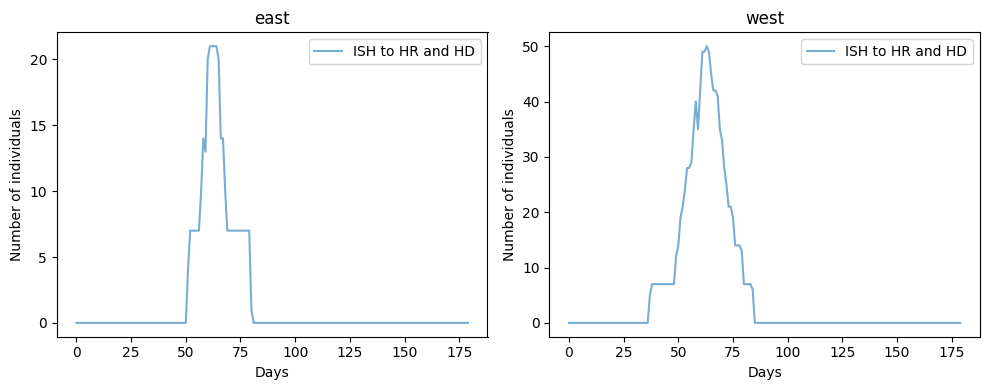

In [10]:
clt.plot_metapop_TransitionVariable(flu_demo_model)

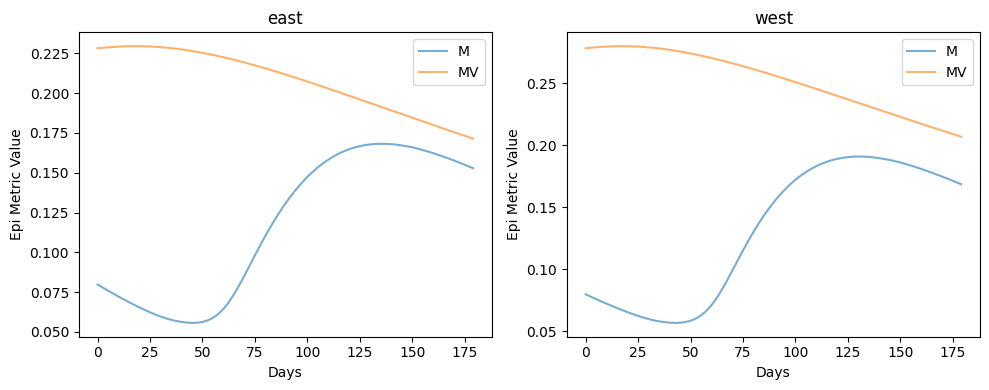

In [11]:
clt.plot_metapop_epi_metrics(flu_demo_model)

In [12]:
# Print the %population exposed for east and west Austin,
# knowing that some individuals are exposed twice since have R to S, many protected by immunity, but possibly not all
print(round(np.sum(np.asarray(east.transition_variables.S_to_E.history_vals_list))/387413,2))
print(round(np.sum(np.asarray(west.transition_variables.S_to_E.history_vals_list))/543134,2))

0.55
0.61


In [13]:
# Print the per capita number of hospitalizations for east and west Austin
east_IS_to_H = np.asarray(east.transition_variables.ISH_to_HR.history_vals_list) + \
    np.asarray(east.transition_variables.ISH_to_HD.history_vals_list)
west_IS_to_H = np.asarray(west.transition_variables.ISH_to_HR.history_vals_list) + \
    np.asarray(west.transition_variables.ISH_to_HD.history_vals_list)
eastHosp = round(np.sum(east_IS_to_H)/387413*100000)
westHosp = round(np.sum(west_IS_to_H)/543134*100000)
print(eastHosp)
print(westHosp)

82
193


In [14]:
# Compute per capita hospitalization across Austin, weighted average of east and west
# For PHR7, which includes Austin, it was 89.2, flu_instances/texax_flu_hosp_rate_20232024/austin_flu_hosp_rate_20232024
round((eastHosp*387413+westHosp*543134)/(387413+543134))

147

In [15]:
# Timing of infected peak, first for East
# First need to sum over all "I" compartments
infected_compartment_names = [name for name in east.compartments.keys() if "I" in name or "H" in name]
infected_compartments_history = [east.compartments[compartment_name].history_vals_list for compartment_name in infected_compartment_names]
total_infectedE = np.sum(np.asarray(infected_compartments_history), axis=(0, 2, 3))
print(np.argmax(total_infectedE))

# then for West
infected_compartment_names = [name for name in west.compartments.keys() if "I" in name or "H" in name]
infected_compartments_history = [west.compartments[compartment_name].history_vals_list for compartment_name in infected_compartment_names]
total_infectedW = np.sum(np.asarray(infected_compartments_history), axis=(0, 2, 3))
print(np.argmax(total_infectedW))

# and finally total
total_infected = np.asarray(total_infectedE+total_infectedW)
print(np.argmax(total_infectedW))
# Peak hospitalizations was week of 12/30 in Austin and peak 7 day average was day of 1/4 in TX.  Peak infection usually occurs ~2 weeks prior or 12/21 (day 62).
# [Comparing peak ILI and peak in hospitalizations: https://www.cdc.gov/flu/whats-new/flu-summary-2023-2024.html]

63
62
62


In [16]:
# Print the % of recovered that become susceptible again for east and west Austin
# It's the same since this is just based on rates of being recovered and going to susceptible, 
#    which is same in two subpopulations
numRtoS_east = np.sum(np.asarray(east.transition_variables.R_to_S.history_vals_list))
numIAtoR_east = np.sum(np.asarray((east.transition_variables.IA_to_R.history_vals_list)))
numISRtoR_east = np.sum(np.asarray((east.transition_variables.ISR_to_R.history_vals_list)))
numHRtoR_east = np.sum(np.asarray((east.transition_variables.HR_to_R.history_vals_list)))
numR_east = numIAtoR_east + numISRtoR_east + numHRtoR_east
print(round(numRtoS_east/numR_east))

numRtoS_west = np.sum(np.asarray(east.transition_variables.R_to_S.history_vals_list))
numIAtoR_west = np.sum(np.asarray((east.transition_variables.IA_to_R.history_vals_list)))
numISRtoR_west = np.sum(np.asarray((east.transition_variables.ISR_to_R.history_vals_list)))
numHRtoR_west = np.sum(np.asarray((east.transition_variables.HR_to_R.history_vals_list)))
numR_west = numIAtoR_west + numISRtoR_west + numHRtoR_west
print(round(numRtoS_west/numR_west))


1
1


In [17]:
west.epi_metrics.MV.history_vals_list

[array([[0.27824262],
        [0.27824262],
        [0.27824262],
        [0.27824262],
        [0.27793717]]),
 array([[0.2784772 ],
        [0.2784772 ],
        [0.2784772 ],
        [0.2784772 ],
        [0.27786715]]),
 array([[0.27870527],
        [0.27870527],
        [0.27870527],
        [0.27870527],
        [0.27779145]]),
 array([[0.27892385],
        [0.27892385],
        [0.27892385],
        [0.27892385],
        [0.27770711]]),
 array([[0.27913447],
        [0.27913447],
        [0.27913447],
        [0.27913447],
        [0.27761566]]),
 array([[0.27933416],
        [0.27933416],
        [0.27933416],
        [0.27933416],
        [0.27751414]]),
 array([[0.27952593],
        [0.27952593],
        [0.27952593],
        [0.27952593],
        [0.27740557]]),
 array([[0.27970684],
        [0.27970684],
        [0.27970684],
        [0.27970684],
        [0.27728701]]),
 array([[0.27987689],
        [0.27987689],
        [0.27987689],
        [0.27987689],
        [0.27715